# "Causality modelling in Python for data scientists"
> "Data science is increasingly commonplace in industry and the enterprise. Industrial data scientists have a vast toolbox for descriptive and predictive analyses at their disposal. However, data science tools for decision-making in industry and the enterprise are less well established. Here we survey Python packages that can aid industrial data scientists facilitate intelligent decision-making through causality modelling."
- hidden: true
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [causal inference, causal discovery, causality modelling, python]

## The need for causality modelling

Intelligent planning and decision-making lie at the heart of most business success.

The decisions that our business needs to evaluate can range from those that are relatively low effort and we take potentially thousands or millions of times a day to those that are high effort and are taken every couple of months:

1. What will happen if I show an advertising banner to a particular user?
2. What will happen if I change the retail prices for certain products in my shop?
3. What will happen if I alter my manufacturing process?
4. What will happen if I swap out a particular mechanical piece in a vehicle I develop?
5. What will happen if I invest in new property, machinery, or processes?
6. What will happen if I hire this applicant?
7. What if I increase remuneration of my workforce?

As industrial data scientists we are oftentimes called upon to evaluate these proposed business decisions using analytics, machine learning methodologies, and past data.

What we may end up doing for the above proposed business decisions is:

1. Compute and rank past click-through rates for given pairs of ad banner and user,
2. Correlate past demand with set retail prices for product groups of interest,
3. Correlate past manufacturing parameters with achieved output quality,
4. Correlate the mechanical behavior of my vehicles with the mechnical parts used in it,
5. Use past data to forecast the development of real estate prices,
6. Use past data to correlate and predict the productivity of my team given e.g. its size or makeup, and
7. Use past data to correlate productivity and remuneration levels.

The way I formulated these is already pretty suggestive - but essentially some of our common approaches to evaluating business decisions do not compare our business outcomes with and without said business decisions but they rather look at our data outside the context of decision-making.

Put another way, we oftentimes analyze past data without considering the state our business or customer is in when those data were generated.
For illustration:

![Data fusion process (5)](https://user-images.githubusercontent.com/3273502/85201681-a999f580-b301-11ea-9174-056649a1bebb.png)

So really when tasked with evaluating the above proposed business decisions we should instead think in terms of questions akin the following:

1. How would the user of interest behave differently if we didn't show them (and pay for) a banner now?
2. For each Euro we shave off a price tag how much higher will our revenue be since more customers are inclinced to place an order?
3. 
4.
5.
6.
7.

## How to do causality modelling

The authors Hünermund and Bareinboim (https://arxiv.org/abs/1912.09104) proposed a methodology they called data-fusion process.

The data-fusion process maps out the individual steps necessary for evaluating the impact of past and potential future decisions:

![The data-fusion process.](https://user-images.githubusercontent.com/3273502/85201682-aacb2280-b301-11ea-9529-59e63c19f945.png "With the data-fusion process we iterate through applying and validating our causal understanding of our system, modelling the impact of our proposed business decision on our system, and estimate its impact using our validated causal model and historical data. Adapted from Hünermund and Bareinboim: https://arxiv.org/abs/1912.09104.")

## Use case: The impact of direct marketing on customer behavior

We'll use a data set provided by UCI (https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) that demonstrates the potential impact of direct marketing on customer success.

Let's dive right in, download the data set and see what we are working with.

### The direct marketing success data set

In [1]:
!wget --quiet https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

In [2]:
!unzip -oqq bank.zip

In [1]:
import pandas as pd

In [51]:
#collapse
df = pd.read_csv('bank.csv', delimiter=';')
df['success'] = df['y']
del df['y']
df['success'] = df['success'].replace('no', 0)
df['success'] = df['success'].replace('yes', 1)
del df['duration']
df['no_contacts'] = df['campaign']
del df['campaign']

In [52]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,pdays,previous,poutcome,success,no_contacts
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,-1,0,unknown,0,1
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,339,4,failure,0,1
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,330,1,failure,0,1
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,-1,0,unknown,0,4
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,-1,0,unknown,0,1


Our tabular marketing and sales data shows a number of features we observe about a given customer and our interaction with them:

- The customer's age, job, marital status, education, current account balance, and whether or not they already took out a loan are recorded,
- Our direct marketing interaction with a given customer is also recorded, for instance, how often we already contacted them.

A more detailed description of the features in our data can be found here:

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing



### Trying to help our business with machine learning only

In [53]:
target = 'success'
features = [column for column in df.columns if column != target]

In [54]:
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder

In [55]:
model = lgb.LGBMClassifier()

In [56]:
X, y = df[features], df[target]

In [57]:
numerical_features = ['age', 'balance', 'no_contacts', 'previous', 'pdays']
categorical_features = [feature for feature in features if feature not in numerical_features]

In [58]:
encoder = OrdinalEncoder(dtype=int)

In [59]:
X_numeric = pd.concat(
    [
        X[numerical_features],
        pd.DataFrame(
            data=encoder.fit_transform(X[categorical_features]),
            columns=categorical_features
        )
    ],
    axis=1
)

In [60]:
X_numeric.head()

,age,balance,no_contacts,previous,pdays,job,marital,education,default,housing,loan,contact,day,month,poutcome
0,30,1787,1,0,-1,10,1,0,0,0,0,0,18,10,3
1,33,4789,1,4,339,7,1,1,0,1,1,0,10,8,0
2,35,1350,1,1,330,4,2,2,0,1,0,0,15,0,0
3,30,1476,4,0,-1,4,1,2,0,1,1,2,2,6,3
4,59,0,1,0,-1,1,1,1,0,1,0,2,4,8,3


In [61]:
model.fit(X_numeric, y)

LGBMClassifier()

In [62]:
%matplotlib inline

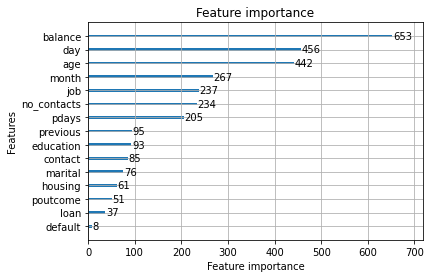

In [63]:
lgb.plot_importance(model);

There are numerous ways to compute feature importance and this one implemented in the LightGBM library measures the number of times a given feature is used in the constructed trees:

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html

In general, feature importance gives us a measure of how well a given measured variable correlates with the target (marketing success in our case).

The question here is: How can we use our trained success predictor and our feature importances to aid intelligent plannning and decision-making in our business?

### Uses for 